# Week 3: Fitting

In many different cases, we might have a model for how a system works, and want to fit that model to a set of observations. 

We're going to investigate the process of fitting using a classic paper that proposed a model for the [T cell receptor](https://www.ncbi.nlm.nih.gov/pubmed/11606269). Here, the authors develop a mathematical model for how binding occurs and then have observations of how much binding occurs under specific conditions. Identifying whether and how this model fits has led to a better understanding of how our immune system recognizes diseased cells, and how to design T cells that respond to diseases like cancer.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from scipy.special import binom
from scipy.optimize import least_squares
from sklearn.utils import resample

np.seterr(over='raise')

def StoneMod(Rtot, Kd, v, Kx, L0):
    '''
    Returns the number of mutlivalent ligand bound to a cell with Rtot
    receptors, granted each epitope of the ligand binds to the receptor
    kind in question with dissociation constant Kd and cross-links with
    other receptors with crosslinking constant Kx. All eq derived from Stone et al. (2001).
    '''
    v = np.int_(v)
    
    assert L0.shape == v.shape
    
    # Mass balance for receptor species, to identify the amount of free receptor
    diffFunAnon = lambda x: Rtot-x*(1+v*L0*(1/Kd)*(1+Kx*x)**(v-1))
    
    ## Solve Req by calling least_squares
    lsq = least_squares(diffFunAnon, np.full_like(L0, Rtot/2.0), jac_sparsity=np.eye(L0.size),
                        max_nfev=1000, xtol=1.0E-10, ftol=1.0E-10, gtol=1.0E-10,
                        bounds=(np.full_like(L0, -np.finfo(float).eps), np.full_like(L0, Rtot)))
    if not lsq['success']:
        print(lsq)
        raise RuntimeError("Failure in solving for Req.")
        
    Req = lsq.x
    Lbound = np.zeros(Req.size)
    Rmulti = np.zeros(Req.size)
    Rbnd = np.zeros(Req.size)
    
    for ii, Reqq in enumerate(Req):
        # Calculate vieq from equation 1
        vieq = L0[ii]*Reqq*binom(v[ii], np.arange(1, v[ii] + 1))*np.power(Kx*Reqq, np.arange(v[ii]))/Kd

        # Calculate L, according to equation 7
        Lbound[ii] = np.sum(vieq)

        # Calculate Rmulti from equation 5
        Rmulti[ii] = np.dot(vieq[1:], np.arange(2, v[ii] + 1, dtype=np.float))

        # Calculate Rbound
        Rbnd[ii] = Rmulti[ii] + vieq[0]

    return (Lbound, Rbnd, Rmulti)

Xs = np.array([8.1E-11, 3.4E-10, 1.3E-09, 5.7E-09, 2.1E-08, 8.7E-08, 3.4E-07, 1.5E-06, 5.7E-06, 2.82E-11, 1.17E-10, 4.68E-10, 1.79E-09, 7.16E-09, 2.87E-08, 1.21E-07, 4.5E-07, 1.87E-06, 1.64E-11, 6.93E-11, 2.58E-10, 1.11E-09, 4.35E-09, 1.79E-08, 7.38E-08, 2.9E-07, 1.14E-06])
Ys = np.array([-196, -436, 761, 685, 3279, 7802, 11669, 12538, 9012, -1104, -769, 1455, 2693, 7134, 11288, 14498, 16188, 13237, 988, 1734, 4491, 9015, 13580, 17159, 18438, 18485, 17958])
Vs = np.repeat([2, 3, 4], 9)

#### (1) We will fit the data contained within Fig. 3B. Plot this data and describe the relationship you see between Kx, Kd, and valency.

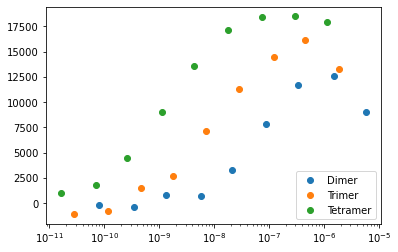

In [2]:
# Answer
X1 = Xs[0:9]
X2 = Xs[9:18]
X3 = Xs[18:27]
Y1 = Ys[0:9]
Y2 = Ys[9:18]
Y3 = Ys[18:27]

plt.scatter(X1,Y1, label = "Dimer")
plt.scatter(X2,Y2,label = "Trimer")
plt.scatter(X3,Y3,label = "Tetramer")
plt. semilogx()
plt.legend(loc = "lower right")
plt.show;



We can see that valency only relates to CD3 as the greater the valency, the more CD3 that binds.

#### (2) First, to do so, we'll need a function that takes the model predictions, scales them to the units of the actual measurements, and finds the predictions for each condition. Define a scaling parameter and a function that takes it along with the other parameters to make predictions about the experiment.

Use the fit parameters shown in Table 1 (row 2) and overlay with the measurements to ensure your function is working. (Scale = 1 for now.)

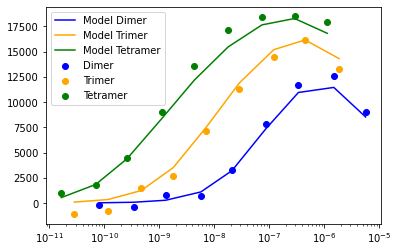

In [3]:
# Answer
#CD3

# Kd = 1.7
# Kx = 3.15
# Rtot = 24000
# Vs = np.repeat([2, 3, 4], 9)
# L0 = Xs
Kd = 1.7E-6
Kx = 3.15E-4
Rtot = 24000

def problem2(scaling = 1, Rtot = 24000, Kd = 1.7E-6, v = Vs, Kx = 3.15E-4, L0 = Xs):
    Xs = L0
    LBound, Rbnd,Rmulti = StoneMod(Rtot, Kd, v, Kx, L0)
    Rmulti = Rmulti * scaling

    return Rmulti
Ys = np.array([-196, -436, 761, 685, 3279, 7802, 11669, 12538, 9012, -1104, -769, 1455, 2693, 7134, 11288, 14498, 16188, 13237, 988, 1734, 4491, 9015, 13580, 17159, 18438, 18485, 17958])
Vs = np.repeat([2, 3, 4], 9)
X1 = Xs[0:9]
X2 = Xs[9:18]
X3 = Xs[18:27]
Y1 = Ys[0:9]
Y2 = Ys[9:18]
Y3 = Ys[18:27]
plt.scatter(X1,Y1, label = "Dimer", color = 'blue')
plt.scatter(X2,Y2,label = "Trimer", color = 'orange')
plt.scatter(X3,Y3,label = "Tetramer",color = 'green')
plt. semilogx()
plt.legend(loc = "upper left")
plt.show;

Rmulti = problem2()



Y1 = Rmulti[0:9]
Y2 = Rmulti[9:18]
Y3 = Rmulti[18:27]

plt.plot(X1,Y1, label = "Model Dimer",color = 'blue')
plt.plot(X2,Y2,label = "Model Trimer", color = 'orange')
plt.plot(X3,Y3,label = "Model Tetramer", color = 'green')
plt. semilogx()
plt.legend(loc = "upper left");


    





#### (3) Now use `scipy.optimize.least_squares` to find the least squares solution.

In [4]:
# Answer
#Find the best Kd, Kx, and scale through least squares

Xs = np.array([8.1E-11, 3.4E-10, 1.3E-09, 5.7E-09, 2.1E-08, 8.7E-08, 3.4E-07, 1.5E-06, 5.7E-06, 2.82E-11, 1.17E-10, 4.68E-10, 1.79E-09, 7.16E-09, 2.87E-08, 1.21E-07, 4.5E-07, 1.87E-06, 1.64E-11, 6.93E-11, 2.58E-10, 1.11E-09, 4.35E-09, 1.79E-08, 7.38E-08, 2.9E-07, 1.14E-06])
Ys = np.array([-196, -436, 761, 685, 3279, 7802, 11669, 12538, 9012, -1104, -769, 1455, 2693, 7134, 11288, 14498, 16188, 13237, 988, 1734, 4491, 9015, 13580, 17159, 18438, 18485, 17958])
Vs = np.repeat([2, 3, 4], 9)
# scaling = 1, Rtot = 24000, Kd = 1.7E-6, v = Vs, Kx = 3.15E-4, L0 = Xs

def ls_p2(values, Xs, Vs):
    return(problem2(values[0],Rtot, values[1], Vs, values[2], Xs))
def error_p2(values, Xs, Ys, Vs):
    return(Ys-ls_p2(values, Xs, Vs))

start = np.array([1,1E-6,3E-4])
sol = least_squares(error_p2,start,args = (Xs,Ys,Vs))

print("Scaling Factor " + str(sol.x[0]))
print("K_d: " + str(sol.x[1]))
print("K_x: " +str(sol.x[2]))




Scaling Factor 1.0281500749895436
K_d: 1.7028603554984148e-06
K_x: 0.00031473142478081215


#### (4) Using leave-one-out crossvalidation, does this model predict the data? Plot the measured vs. predicted data.

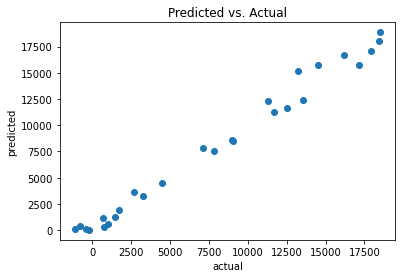

In [5]:
# Answer
from sklearn.model_selection import LeaveOneOut
y_pred = np.empty_like(Ys)
LOOCV = LeaveOneOut()
for train, test in LOOCV.split(Xs):
    sol = least_squares(error_p2,start,args = (Xs[train],Ys[train],Vs[train]))
    y_pred[test] = ls_p2(sol.x, Xs[test],Vs[test])
plt.scatter(Ys,y_pred)
plt.ylabel('predicted')
plt.xlabel('actual')
plt.title('Predicted vs. Actual')
plt.show()


Yes, there is a pretty linear relationship between actual and predicted along the y = x line

#### (5) Using bootstrap estimation, plot the confidence interval of the model predictions along with the data points.
"Confidence interval" does not have a precise definition. For example, you could show the interval over which 50% of the bootstrap samples fall (25th to 75th quantile).

In [6]:
# Answer
p_boot = np.empty(shape = (3,100))
# scaling = 1, Rtot = 24000, Kd = 1.7E-6, v = Vs, Kx = 3.15E-4, L0 = Xs

for bootstrapi in range(p_boot.shape[1]):
    resamp = resample(range(Xs.shape[0]))

    res = least_squares(error_p2,start, args =(Xs[resamp],Ys[resamp], Vs[resamp]))
    p_boot[:,bootstrapi] = res.x

finaldata = np.empty(shape = (27,100))

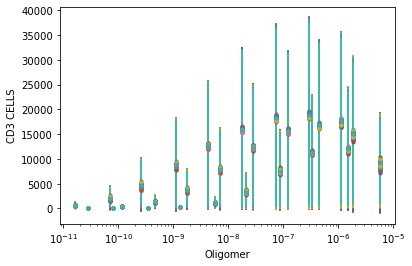

In [7]:
for i in range(0,100):
    finaldata[:,i] = problem2(p_boot[0,i], Rtot, p_boot[1,i], Vs, p_boot[2,i], Xs)
    
plt.semilogx()
lowerQuart = np.empty(27)
upperQuart = np.empty(27)

for j in range(0,27):
    lowerQuart[j] = np.percentile(finaldata[j,:], 25)
    upperQuart[j] = np.percentile(finaldata[j,:], 75)

plt.xlabel("Oligomer")
plt.ylabel("CD3 CELLS")
    
    
for k in range(0,100):
    plt.errorbar(Xs, finaldata[:,k], yerr = (lowerQuart, upperQuart), fmt = '.')
    


# #COME BACK TO THIS BOXPLOTSUH
# f1 = plt.figure()
# ax1 = f1.add_subplot(111)
# ax1.boxplot(p_boot[0,:])
# plt.xlabel('Value')
# plt.ylabel('Scaling Factor')

# f2 = plt.figure()
# ax1 = f2.add_subplot(111)
# ax1.boxplot(p_boot[1,:])
# plt.ylabel('Value')
# plt.xlabel('K_d')

# f3 = plt.figure()
# ax1 = f3.add_subplot(111)
# ax1.boxplot(p_boot[2,:])
# plt.ylabel('Value')
# plt.xlabel('K_x')


# # plt.scatter(p_boot[0, :], p_boot[1, :], s=0.2)
# # plt.xlabel(r"$x_1$")
# # plt.ylabel(r"$x_2$");

#### (6) How would you expect the cross-validation and bootstrap results to change if you had fewer data points?

Explain your answer.

Answer. 

CV might have more trouble as we have less training data to work off of thus raising our prediction error. Testing data would also be questionable because our data would be so small. While bootstrapping can potentially increase our testomg and give a better training data set for our model, it is still limited by the fewer data points which will still drive up the prediction error.

#### (7) Now, we will perform a local sensitivity analysis to look at the dependence of the model results on each parameter. Vary each parameter up and down by 10-fold **while holding the others constant**, and plot the sum of squared error. Which parameter influences the fit the most? Which one the least?

In [8]:
start = np.array([1,1E-6,3E-4])
sol = least_squares(error_p2,start,args = (Xs,Ys,Vs))
print("Scaling Factor " + str(sol.x[0]))
print("K_d: " + str(sol.x[1]))
print("K_x: " +str(sol.x[2]))

x = np.logspace(-1,1,50)
valuesOG = [sol.x[0], sol.x[1], sol.x[2]]
error1 = []
error2 = []
error3 = []

Scaling Factor 1.0281500749895436
K_d: 1.7028603554984148e-06
K_x: 0.00031473142478081215


In [9]:
for i in range(len(x)):
    values = valuesOG.copy()
    values[0] = valuesOG[0]*x[i]
    error1.append(np.sum(error_p2(values, Xs, Ys, Vs))**2)
for i in range(len(x)):
    values = valuesOG.copy()
    values[1] = valuesOG[1]*x[i]
    error2.append(np.sum(error_p2(values, Xs, Ys, Vs))**2)
for i in range(len(x)):
    values = valuesOG.copy()
    values[2] = valuesOG[2]*x[i]
    error3.append(np.sum(error_p2(values, Xs, Ys, Vs))**2)
error1.append(np.sum(error_p2(valuesOG, Xs, Ys, Vs))**2)   
error2.append(np.sum(error_p2(valuesOG, Xs, Ys, Vs))**2)
error3.append(np.sum(error_p2(valuesOG, Xs, Ys, Vs))**2)

In [10]:
x = np.append(x,[1])

# np.append(x,0)

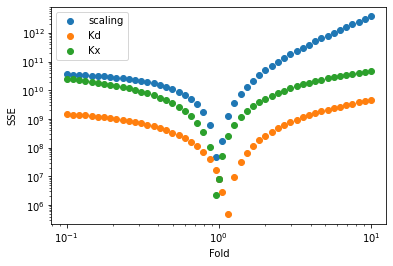

In [11]:
plt.semilogx()
plt.semilogy()
plt.scatter(x,error1, label = "scaling")
plt.scatter(x,error2, label = "Kd")
plt.scatter(x,error3, label = "Kx")
plt.xlabel('Fold')
plt.ylabel('SSE')
# plt.scatter(0,np.sum(error_p2(valuesOG, Xs, Ys, Vs))**2)
# plt.xticks([])
# plt.xticks([-10,0, 10],[.1,1,10])
plt.legend(loc = "upper left");

Kd influences the least causing the least error, scaling influences the most with the most error. Based on error differences.

#### (8) While easier to perform, a local sensitivity analysis ignores codependency between the parameters. Do you anticipate your predictions of the parameter values will be more or less specified with a global analysis?

Answer.

It's better to do global so you can find your global minima as it takes in a greater range of data. Because we are only on local analysis, we are only finding local minima on traces. More specified with global analysis-

#### (9) Now, vary each parameter from the optimal solution, *allowing the other parameters to vary*. Was your prediction true? How might the other parameters be varying when $K_d$ increases?

Hint: The easiest way to do this is mess with the bounds of the least squares solver.

In [12]:
scaling = 1
size = 20
val = np.array(([scaling],[Kd],[Kx]))
scale = np.array([np.logspace(-0.9,0.9,size)])
# print(scale)
a = np.dot(val,scale).transpose()
# print(a)
error = np.zeros((size,3))

#scaling
for i in range(size):
    start = [a[i,0],Kd,Kx]
    sol = least_squares(error_p2,start,args = (Xs,Ys,Vs), bounds = ([a[i,0]-a[i,0]*1E-9, 0, 0],[a[i,0]+a[i,0]*1E-9, np.inf, np.inf]))
    error[i,0] = np.sum(error_p2(sol.x,Xs,Ys,Vs)**2)

for i in range(size):
    start = [scaling,a[i,1],Kx]
    sol = least_squares(error_p2,start,args = (Xs,Ys,Vs), bounds = ([0, a[i,1] - 1E-9, 0],[np.inf,a[i,1]+1E9, np.inf]))
    error[i,1] = np.sum(error_p2(sol.x,Xs,Ys,Vs)**2)
    
for i in range(size):
    start = [scaling,Kx,a[i,2]]
    sol = least_squares(error_p2,start,args = (Xs,Ys,Vs), bounds = ([0, 0, a[i,2]-a[i,2]*1E-9],[np.inf, np.inf, a[i,2]+a[i,2]*1E-9]))
    error[i,2] = np.sum(error_p2(sol.x,Xs,Ys,Vs)**2)   


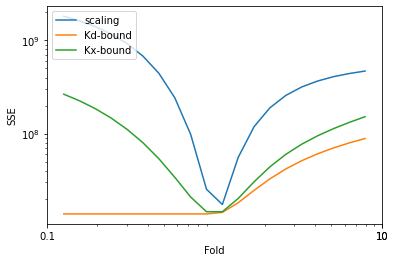

In [13]:
# Answer

#bounds: bounds = ([lb1, lb2, lb3], [ub1, ub2, ub3])



plt.plot(scale[0], error[:,0], label = "scaling")
plt.plot(scale[0], error[:,1], label = "Kd-bound")
plt.plot(scale[0], error[:,2], label = "Kx-bound")
plt.semilogx()
plt.semilogy()
plt.xlabel('Fold')
plt.ylabel('SSE')
plt.xticks([.1,10, 10],[.1,1,10])
plt.legend(loc = "upper left");







Predicting along the same logic, we see that varying the different forms will still maintain that Kd-bound variation has the least SSE. As Kd increases within the bounds, the other parameters have no bounds to range but since Kd is restricted it may cause the other parameters to go through greater variation to accomodoate and decrease errors.

#### (10) At the same time as providing the number of multimerized receptors, the model also infers the quantities of other properties, such as the amount of ligand and receptor bound. Using the bootstrap estimates, plot the confidence in these other parameters.

In [14]:
# Answer


total = np.array((3,100))
Lbnds = []
Rbnds = []
Rmultis = []
V = np.array([2])
X = np.array([1E-10])

for kd in p_boot[1,:]:
    a,b,c = StoneMod(Rtot,kd,V,Kx,X)
    Lbnds.append(a)
    Rbnds.append(b)
    Rmultis.append(c)
for kx in p_boot[2,:]:
    a,b,c = StoneMod(Rtot,Kd,V,kx,X)
    Lbnds.append(a)
    Rbnds.append(b)
    Rmultis.append(c)
for i in p_boot[0,:]:
    Lbnd,Rbnd,_ = StoneMod(Rtot,Kd,V,Kx,X)
    Rmulti = problem2(i, Rtot, Kd, V, Kx,X)
    Lbnds.append(Lbnd)
    Rbnds.append(Rbnd)
    Rmultis.append(Rmulti)
    

Lbnds = np.array(Lbnds)
Rbnds = np.array(Rbnds)
Rmultis = np.array(Rmultis)



confidence interval: 0.8761774117548509


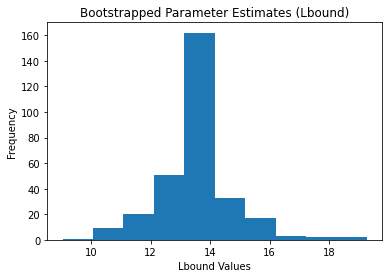

confidence interval: 1.6729729385352137


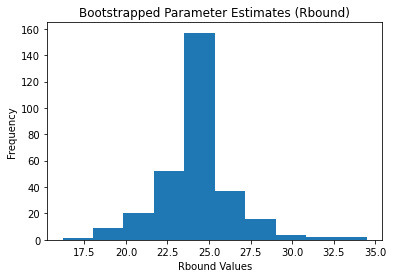

confidence interval: 2.042969884286798


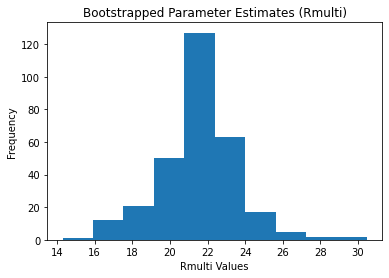

In [15]:
plt.hist(Lbnds)
confidence = np.quantile(Lbnds,0.75)-np.quantile(Lbnds,0.25)
print('confidence interval: ' + str(confidence))
plt.title('Bootstrapped Parameter Estimates (Lbound)')
plt.xlabel('Lbound Values')
plt.ylabel('Frequency')
plt.show()



plt.hist(Rbnds)
confidence = np.quantile(Rbnds,0.75)-np.quantile(Rbnds,0.25)
print('confidence interval: ' + str(confidence))
plt.title('Bootstrapped Parameter Estimates (Rbound)')
plt.xlabel('Rbound Values')
plt.ylabel('Frequency')
plt.show()


plt.hist(Rmultis)
confidence = np.quantile(Rmultis,0.75)-np.quantile(Rmultis,0.25)
print('confidence interval: ' + str(confidence))
plt.title('Bootstrapped Parameter Estimates (Rmulti)')
plt.xlabel('Rmulti Values')
plt.ylabel('Frequency')
plt.show()

In [16]:
# # Answer Trash code

# sol = least_squares(error_p2,start,args = (Xs,Ys,Vs))
# print("Scaling Factor " + str(sol.x[0]))
# print("K_d: " + str(sol.x[1]))
# print("K_x: " +str(sol.x[2]))

# values = sol.x
# print(values)

# #error: np.sum(functionstonemod)**2

# x = []
# error1 = []
# error2 = []
# error3 = []
# valuesOG = [sol.x[0], sol.x[1], sol.x[2]]
# for i in range(1,11):
#     values = valuesOG.copy()
#     values[0] = valuesOG[0]*i
#     x.append(i)
#     x.append(-i)
#     error1.append(np.sum(error_p2(values, Xs, Ys, Vs))**2)
#     values[0] = valuesOG[0]/i
#     error1.append(np.sum(error_p2(values, Xs, Ys, Vs))**2)
    
#     values = valuesOG.copy()
#     values[1] = valuesOG[1]*i
#     error2.append(np.sum(error_p2(values, Xs, Ys, Vs))**2)
#     values[1] = valuesOG[1] / i
#     error2.append(np.sum(error_p2(values, Xs, Ys, Vs))**2)
    
#     values = valuesOG.copy()
#     values[2] = valuesOG[2]*i
#     error3.append(np.sum(error_p2(values, Xs, Ys, Vs))**2)
#     values[2] = valuesOG[2] / i
#     error3.append(np.sum(error_p2(values, Xs, Ys, Vs))**2)
    
# # print(len(error))

# error1x = error1[1:20:2]
# x1x = x[1:20:2]

# plt.semilogy()
# plt.scatter(x,error1, label = "scaling")
# plt.scatter(x,error2, label = "Kd")
# plt.scatter(x,error3, label = "Kx")
# plt.scatter(0,np.sum(error_p2(valuesOG, Xs, Ys, Vs))**2)
# plt.xticks([])
# plt.xticks([-10,0, 10],[.1,1,10])
# plt.legend(loc = "upper left");


# print(error1x)
# #[1,-1,2,-2...]
# #[error1 error[1], error[/1] error[2], error]

In [17]:
#HI